<a target="_blank" href="http://colab.research.google.com/github/woflydev/odyssey_nnn/blob/main/utils/notebooks/backup_training.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a>

In [18]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib
from sklearn.model_selection import train_test_split
from skimage.exposure import match_histograms
from pandas import read_csv
from skimage import io
from tqdm import tqdm
import numpy as np
import math
import cv2
import os

# from skimage import data

os.environ['CUDA_VISIBLE_DEVICES'] = "0"

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()

Num GPUs Available: 0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16000488008266872619
 xla_global_id: -1]

In [19]:
# input image resolution to the DNN model (smaller than the original dataset image resolution: 320x240x3)
# new camera has width and height of (640, 360)
img_width = 320
img_height = 180
img_channels = 3

model_name = "model_opt"
model_file = "models/{}-{}x{}x{}".format(model_name[6:], img_width, img_height, img_channels)
pre="resize" # [resize|crop]

In [20]:
import requests 
import os
import zipfile

#dataset_dir = "data/dataset"
dataset_zipfile = 'Dataset-kucsl-Apr2022.zip' # 'labtrack-leftonly-RTCSA22.zip' # 'Dataset.zip'
RunningInCOLAB = 'google.colab' in str(get_ipython())
force_unzip = True
use_match_histogram = False

dataset_path = "C:\\Users\\wolfy\\Desktop\\odyssey_nnn\\data\\dataset\\*.mp4"

if RunningInCOLAB: 
    dataset_path = "data/dataset/*.mp4"
    print("in colab")
    from google.colab import files
    uploaded = files.upload()
    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))
        dataset_zipfile = fn  # expecting a zip file to be uploaded. 
else:
    print ("not in colab")
    pass
    # RPI_IP=None # replace this with the IP address of your raspberry pi 
    # if RPI_IP is not None:
    #     URL="http://"+RPI_IP+":8000/"+dataset_zipfile
    #     filename=URL.split('/')[-1]
    #     r = requests.get(URL)
    #     open(filename, 'wb').write(r.content)

if not os.path.isfile(dataset_zipfile):
    #default_dataset_URL = "https://raw.githubusercontent.com/heechul/DeepPicar-v3/devel/Dataset-kucsl-Apr2022.zip"    
    ##print ("No existing dataset. download from ", default_dataset_URL)
    #r = requests.get(default_dataset_URL)
    #open(dataset_zipfile, 'wb').write(r.content)
    pass

#if not os.path.isdir(dataset_dir) or force_unzip==True:
    #print ('unzip %s into %s folder' % (dataset_zipfile, dataset_dir))
    #zip_ref = zipfile.ZipFile(dataset_zipfile)
    #zip_ref.extractall(dataset_dir)
    #pass

not in colab


In [ ]:
# run this first
#!pip uninstall --yes gdown # After running this line, restart Colab runtime.

# then this
#!pip install --upgrade --no-cache-dir gdown

# replace this with id from gdrive
if RunningInCOLAB:
	!gdown 1vYk-O9FKNUJPsnRDpyxiGqiPBvjCZ0L8
	# unzip
	!unzip dataset.zip -d dataset/

In [21]:
if use_match_histogram:
    refs = []
    num_spectrums = 5
    size = img_width*img_height
    num_colors = int(256 / num_spectrums)
    color_pixels = int(size / num_colors)
    color = 0
    for s in range(num_spectrums): 
        num_color = 0
        img = []
        for i in range(img_height):
            img.append([])
            for j in range(img_width):
                img[i].append([])
                #for k in range(3):
                img[i][j].append(color)
                img[i][j].append(color)
                img[i][j].append(color)
                num_color += 1
                if num_color == color_pixels - 1:
                    if not color == 255:
                        color += 1
                    num_color = 0            
        img = np.asarray(img, dtype=np.uint8) / 255.
        refs.append(img)

In [22]:
# Train/test data lists
imgs = []
vals = []

SHOW_IMAGE_FOR_DEBUG = False

import glob

def rad2deg(rad):
	return 180.0 * rad / math.pi

def crop_image(img):
	scaled_img = cv2.resize(img, (max(int(img_height * 4 / 3), img_width), img_height))
	fb_h, fb_w, fb_c = scaled_img.shape
	# print(scaled_img.shape)
	startx = int((fb_w - img_width) / 2)
	starty = int((fb_h - img_height) / 2)
	return scaled_img[starty:starty+img_height, startx:startx+img_width,:]

speed_iter = 0
for vid_file_path in glob.iglob(dataset_path):
	csv_file_path = vid_file_path.replace('video', 'key').replace('mp4', 'csv') #used to be avi but different encoding now
	print(vid_file_path, csv_file_path)
	
	vid = cv2.VideoCapture(vid_file_path)
	speed_values = True

	try:
		df = read_csv(csv_file_path)
		tmp = df["speed"].values[0]
	except:
		speed_values = False
		print("csv has no values / speed!")

	speed_iter = 0
	for val in df["wheel"].values:
		ret,img = vid.read()
		if ret is not False:
			if speed_values:
				if df["speed"][speed_iter] <= 3:
					#print("speed value not high enough!")
					pass

			speed_iter += 1

			if pre == "crop":
				img = crop_image(img)
				print(img.shape)
			else:
				img = cv2.resize(img, (img_width, img_height))

			# Convert to grayscale and readd channel dimension
			#if img_channels == 1:
					#img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
					#img = np.reshape(img, (img_height, img_width, img_channels))

			if speed_iter < 3500: # <--- only limits when in google colab
				img = (img / 255.).astype(np.float64) # <--- prevents ram overload
				if SHOW_IMAGE_FOR_DEBUG:
					cv2.imshow("normalized", img)
					cv2.waitKey(0)
					cv2.destroyAllWindows()

				imgs.append(img)
				vals.append(val)
				
				speed_iter += 1 if RunningInCOLAB else 0 #checks for colab, and limits iterations to prevent ram overload
			else:
				print("too many images, will cause colab to crash!")

			if use_match_histogram == True:
				for i in range(num_spectrums):
					img = match_histograms(img, refs[i], multichannel=True) # channel_axis=-1
		else:
			print("video seems to be empty. nothing to do!")
			continue
print(len(imgs), len(vals))

# Convert lists to numpy arrays and ensure they are of equal length    
imgs = np.asarray(imgs)  # input images
vals = np.asarray(vals)  # steering angles
assert len(imgs) == len(vals)
print("Loaded {} samples".format(len(imgs)))

C:\Users\wolfy\Desktop\odyssey_nnn\data\dataset\out-video-10.mp4 C:\Users\wolfy\Desktop\odyssey_nnn\data\dataset\out-key-10.csv
C:\Users\wolfy\Desktop\odyssey_nnn\data\dataset\out-video-17.mp4 C:\Users\wolfy\Desktop\odyssey_nnn\data\dataset\out-key-17.csv
C:\Users\wolfy\Desktop\odyssey_nnn\data\dataset\out-video-2.mp4 C:\Users\wolfy\Desktop\odyssey_nnn\data\dataset\out-key-2.csv
C:\Users\wolfy\Desktop\odyssey_nnn\data\dataset\out-video-40.mp4 C:\Users\wolfy\Desktop\odyssey_nnn\data\dataset\out-key-40.csv
C:\Users\wolfy\Desktop\odyssey_nnn\data\dataset\out-video-42.mp4 C:\Users\wolfy\Desktop\odyssey_nnn\data\dataset\out-key-42.csv
C:\Users\wolfy\Desktop\odyssey_nnn\data\dataset\out-video-46.mp4 C:\Users\wolfy\Desktop\odyssey_nnn\data\dataset\out-key-46.csv
video seems to be empty. nothing to do!
video seems to be empty. nothing to do!
video seems to be empty. nothing to do!
video seems to be empty. nothing to do!
video seems to be empty. nothing to do!
video seems to be empty. nothing t

In [23]:
if use_match_histogram:
    fig, axises = plt.subplots(nrows=1, ncols=num_spectrums+1, figsize=(8, 4),
                                        sharex=True, sharey=True)
    for i in range(num_spectrums+1):
        aa = axises[i]
        aa.imshow(imgs[240 + i])
    plt.tight_layout()
    plt.show()

In [24]:
# Split the dataset for train and test 
print("Splitting the dataset for training and testing...")
x_train, x_test, y_train, y_test = train_test_split(imgs, vals, test_size=0.25)

Splitting the dataset for training and testing...


In [25]:
len(x_train)

3494

In [26]:
from keras import layers

use_depthmodel = False

if use_depthmodel == True: 
  h_len = img_height
  w_len = img_width
  d_len = img_channels

  depth_multiplier = 1.0
  dw_conv_str="1111"
  fc_str="111"
  # depthwise convolution model (doesn't work for some reason!!!)
  model = tf.keras.Sequential()
  
  dw_conv_arr = []
  dw_conv_arr.append(layers.DepthwiseConv2D((5,5), strides=(2, 2)))
  dw_conv_arr.append(layers.Conv2D(round(36 * depth_multiplier), (1, 1), strides=(1, 1)))

  dw_conv_arr.append(layers.DepthwiseConv2D((5,5), strides=(2, 2)))
  dw_conv_arr.append(layers.Conv2D(round(48 * depth_multiplier), (1, 1), strides=(1, 1)))

  dw_conv_arr.append(layers.DepthwiseConv2D((3,3), strides=(1, 1)))
  dw_conv_arr.append(layers.Conv2D(round(64 * depth_multiplier), (1, 1), strides=(1, 1)))

  dw_conv_arr.append(layers.DepthwiseConv2D((3,3), strides=(1, 1)))
  dw_conv_arr.append(layers.Conv2D(round(64 * depth_multiplier), (1, 1), strides=(1, 1)))

  fc_arr = []
  fc_arr.append(layers.Dense(round(100 * depth_multiplier), activation='relu'))
  fc_arr.append(layers.Dense(round(50 * depth_multiplier), activation='relu'))
  fc_arr.append(layers.Dense(round(10 * depth_multiplier), activation='relu'))

  # input layer
  model.add(layers.Input(shape=(h_len,w_len,d_len), name='input'))
  model.add(layers.DepthwiseConv2D((5,5), strides=(2, 2), name='dwi'))
  model.add(layers.Conv2D(round(24 * depth_multiplier), (1, 1), strides=(1, 1), name='pwi'))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())

  # Add Conv2D layers
  # for i in range(len(conv_str)):
  # 	if int(conv_str[i]) == 1:
  # 		model.add(conv2d_arr[i])

  for i in range(0, len(dw_conv_str)):
    if int(dw_conv_str[i]) == 1:
      model.add(dw_conv_arr[i*2])
      model.add(dw_conv_arr[i*2+1])
      model.add(layers.BatchNormalization())
      model.add(layers.ReLU())

  # Add Flatten layer
  model.add(layers.Flatten())

  # Add FC layers
  for i in range(len(fc_str)):
    if int(fc_str[i]) == 1:
      model.add(fc_arr[i])

  # Add final output layer
  model.add(layers.Dense(1, name="output"))

else:
  # original model
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(24, (5,5), strides=(2,2), activation='relu', input_shape=(img_height,img_width,img_channels)))
  model.add(layers.Conv2D(36, (5,5), strides=(2,2), activation='relu'))
  model.add(layers.Conv2D(48, (5,5), strides=(2,2), activation='relu'))
  model.add(layers.Conv2D(64, (3,3), activation='relu'))
  model.add(layers.Conv2D(64, (3,3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(100, activation='relu'))
  model.add(layers.Dense(50, activation='relu'))
  model.add(layers.Dense(10, activation='relu'))
  model.add(layers.Dense(1, name="output"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 88, 158, 24)       1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 77, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 19, 37, 48)        43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 17, 35, 64)        27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 15, 33, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 31680)             0         
                                                                 
 dense (Dense)               (None, 100)               3

In [27]:
print("Quantize to make it extreme zoom...")
if RunningInCOLAB:
  !pip install tensorflow_model_optimization

import tensorflow_model_optimization as tfmot
quantize_model = tfmot.quantization.keras.quantize_model
q_aware_model = quantize_model(model)

print ("Compiling model...")
q_aware_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
		                loss=tf.keras.losses.MeanSquaredError())
q_aware_model.summary()

Quantize to make it extreme zoom...
Compiling model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 180, 320, 3)      3         
 er)                                                             
                                                                 
 quant_conv2d (QuantizeWrapp  (None, 88, 158, 24)      1875      
 erV2)                                                           
                                                                 
 quant_conv2d_1 (QuantizeWra  (None, 42, 77, 36)       21711     
 pperV2)                                                         
                                                                 
 quant_conv2d_2 (QuantizeWra  (None, 19, 37, 48)       43347     
 pperV2)                                                         
                                                                 
 

Model fit
Epoch 1/30
28/28 [==============================] - 74s 2s/step - loss: 0.0604 - val_loss: 0.0623
Epoch 2/30
28/28 [==============================] - 64s 2s/step - loss: 0.0440 - val_loss: 0.0377
Epoch 3/30
28/28 [==============================] - 62s 2s/step - loss: 0.0294 - val_loss: 0.0309
Epoch 4/30
28/28 [==============================] - 58s 2s/step - loss: 0.0220 - val_loss: 0.0377
Epoch 5/30
28/28 [==============================] - 69s 2s/step - loss: 0.0210 - val_loss: 0.0184
Epoch 6/30
28/28 [==============================] - 72s 3s/step - loss: 0.0140 - val_loss: 0.0151
Epoch 7/30
28/28 [==============================] - 53s 2s/step - loss: 0.0124 - val_loss: 0.0163
Epoch 8/30
28/28 [==============================] - 50s 2s/step - loss: 0.0096 - val_loss: 0.0153
Epoch 9/30
28/28 [==============================] - 59s 2s/step - loss: 0.0084 - val_loss: 0.0114
Epoch 10/30
28/28 [==============================] - 72s 3s/step - loss: 0.0075 - val_loss: 0.0104
Epoch 11/

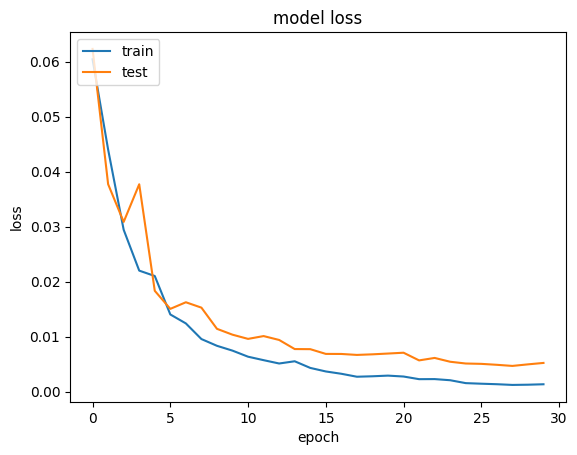

In [28]:
print ("Model fit")
# q_aware_model.reset_states()
history = q_aware_model.fit(x_train, y_train, batch_size=128,
                    epochs=30, validation_data=(x_test, y_test))

# Plot training and validation losses 
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [37]:
angle_thresh = 5
center_thresh = 5
# Helper functions for evaluating model accuracy

def get_action(angle_rad):
  degree = rad2deg(angle_rad)
  if degree < center_thresh and degree > -center_thresh:
    return "center"
  elif degree >= angle_thresh:
    return "right" 
  elif degree <-angle_thresh:
    return "left"
  else:
    return "self-determine"
  
def plot_image(i, prediction_array, groundtrue_array, img_array):
  angle, predicted_label, groundtrue_label, img = int(rad2deg(pred_angle[i])), prediction_array[i], groundtrue_array[i], img_array[i]
  plt.grid(True)
  plt.xticks([])
  plt.yticks([])
  img = np.squeeze(img)
  plt.imshow(img, cmap=plt.cm.binary)
  if predicted_label == groundtrue_label:
    color = 'green'
  else:
    color = 'red'  
  plt.xlabel("Predict:{} ({}) Actual:{}".format(predicted_label,angle,groundtrue_label), color=color)
	
pred_angle = q_aware_model.predict(x_test)
pred = np.array(list(map(get_action, pred_angle)))
ground = np.array(list(map(get_action, y_test)))
print('Accuracy is %.3f' % np.mean(pred == ground))

37/37 [==============================] - 4s 115ms/step
Accuracy is 0.870


visualization

In [38]:
cv2.imshow("test", x_test[4 + 2*3])
cv2.waitKey(0)
cv2.destroyAllWindows()

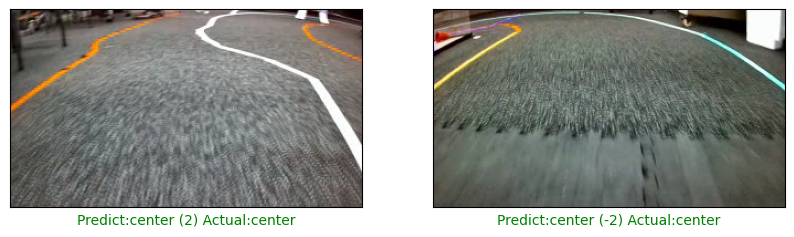

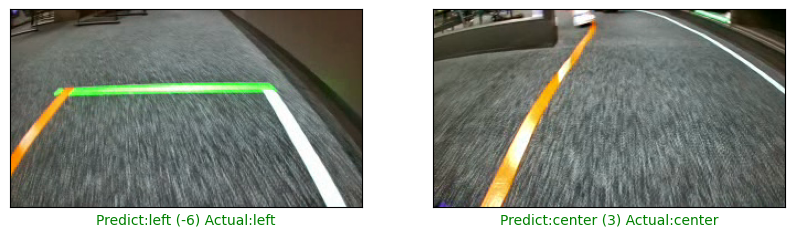

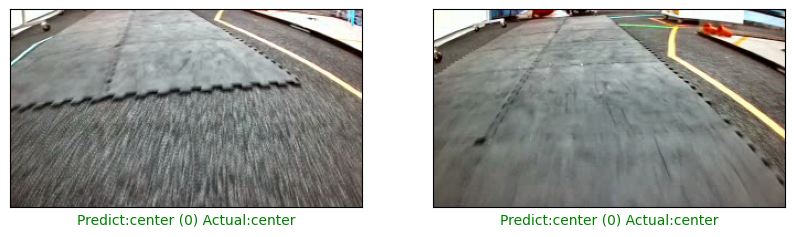

In [47]:
#@title Visualize the outputs { run: "auto" }
index = 2 #@param {type:"slider", min:0, max:244, step:6}
for i in range(3):
  plt.figure(figsize=(10,3))
  plt.subplot(1,2,1)
  plot_image(index + 2*i, pred, ground, x_test)
  plt.subplot(1,2,2)
  plot_image(index + 2*i+1, pred, ground, x_test)
  plt.show()

In [41]:
# Save both the Keras and TFLite models      
print("Model Save")                  
q_aware_model.save(model_file+".h5")

print("TFLite Model")
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

# def representative_data_gen():
#   for input_value in tf.data.Dataset.from_tensor_slices(imgs).batch(1).take(100):
#     yield [input_value]

# converter.representative_dataset = representative_data_gen
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.inference_input_type = tf.int8  # or tf.uint8
# converter.inference_output_type = tf.int8  # or tf.uint8

quantized_tflite_model = converter.convert()

interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)



with open(model_file+".tflite", 'wb') as f:
    f.write(quantized_tflite_model)

if RunningInCOLAB: 
    from google.colab import files
    files.download(model_file+".tflite")
    files.download(model_file+".h5")

Model Save
TFLite Model


INFO:tensorflow:Assets written to: C:\Users\wolfy\AppData\Local\Temp\tmpwnf3n7co\assets


INFO:tensorflow:Assets written to: C:\Users\wolfy\AppData\Local\Temp\tmpwnf3n7co\assets


input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>


C:\Users\wolfy\AppData\Roaming\Python\Python311\site-packages\tensorflow\lite\python\convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [17]:
imgs = []
vals = []

import gc
gc.collect()

from keras import backend as k_backend
k_backend.clear_session()